### Generating the activation maps

This script generates the required activation maps. I have multiple python scripts, one to load the model and data, and one to perform the perform the average maps. I have been unable to share environments and make this into a single bash or python script, so Jupyter it is!

In [1]:
%matplotlib inline
#import tensorflow as tf 
import numpy as np 
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
import random
#import seaborn as sns
from glob import glob
import sys
import os

In [2]:
WindNet_attention={}
'''
    Keys must be of the form attention_type_area_history_delay, where:
    type: 'Total', 'Large', or 'Small' for corresponding wind speeds
    area: 'hole' or 'hot'
'''

"\n    Keys must be of the form attention_type_area_history_delay, where:\n    type: 'Total', 'Large', or 'Small' for corresponding wind speeds\n    area: 'hole' or 'hot'\n"

In [3]:
disc = np.zeros([224,224])
for i in xrange(224):
    for j in xrange(224):
        if np.square(i-112)+np.square(j-112)<=90*90:
            disc[i,j]=1

['hole', 'hot']
(20, 224, 224)
(224, 224)
0.00021217907869259693


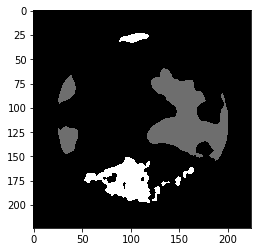

In [4]:
tmp=np.load('../Data/Mask/CrossValidation211/CV_1/Test/Partition103.npy',allow_pickle=True).tolist()
print tmp.keys()
print tmp['hot'].shape
#plt.imshow(tmp['hole'][0,:,:],cmap='hot')
t2=tmp['hole'][0,:]+tmp['hot'][0,:]
t2=t2*disc
print t2.shape
print np.max(tmp['hot'][0,:])
plt.imshow(t2,cmap='gray')

In [5]:
print sorted(glob('../Data/CrossValidation193/CV_1/Test/*.npy'))
print sorted(glob('../Data/Mask/CrossValidation193/CV_1/Test/*.npy'))

['../Data/CrossValidation193/CV_1/Test/Partition1.npy', '../Data/CrossValidation193/CV_1/Test/Partition100.npy', '../Data/CrossValidation193/CV_1/Test/Partition128.npy', '../Data/CrossValidation193/CV_1/Test/Partition129.npy', '../Data/CrossValidation193/CV_1/Test/Partition131.npy', '../Data/CrossValidation193/CV_1/Test/Partition136.npy', '../Data/CrossValidation193/CV_1/Test/Partition137.npy', '../Data/CrossValidation193/CV_1/Test/Partition139.npy', '../Data/CrossValidation193/CV_1/Test/Partition141.npy', '../Data/CrossValidation193/CV_1/Test/Partition142.npy', '../Data/CrossValidation193/CV_1/Test/Partition155.npy', '../Data/CrossValidation193/CV_1/Test/Partition18.npy', '../Data/CrossValidation193/CV_1/Test/Partition20.npy', '../Data/CrossValidation193/CV_1/Test/Partition28.npy', '../Data/CrossValidation193/CV_1/Test/Partition30.npy', '../Data/CrossValidation193/CV_1/Test/Partition31.npy', '../Data/CrossValidation193/CV_1/Test/Partition32.npy', '../Data/CrossValidation193/CV_1/Test/

In [7]:
"""
    Use this code for standard error.
"""
#Generate the delay for one model.
ch_filter = 193
WindNet_attention={}
'''
    Keys must be of the form attention_type_area_history_delay, where:
    type: 'Total', 'Large', or 'Small' for corresponding wind speeds
    area: 'hole' or 'hot'
'''
for history in np.arange(1,5):
    for delay in np.arange(1,5):
        for cv in np.arange(1,6):
            #Get path for the saved model (a.k.a model checkpoint)
            GCsavepath='../Models/WindNet/CrossValidation/'+str(ch_filter)+'/CV_'+str(cv)+'/SDOPred'+str(history)+str(delay)+'/'
            trainpaths_Mask = sorted(glob('../Data/Mask/CrossValidation'+str(ch_filter)+'/CV_'+str(cv)+'/Train/*.npy'))
            GCto=np.load(GCsavepath+'GC_train.npy',allow_pickle=True).tolist()
            bp='../Plots/WindNet/'
            #Obtain the segmented ARs and CHs for the training data.
            Cor_hole=[]
            Hot_reg=[]
            CH_tmp=[]
            Hot_tmp=[]
            for fname in trainpaths_Mask:
                fopen=np.load(fname,allow_pickle=True).tolist()
                CH_tmp.append(np.reshape(fopen['hole'],[-1,224,224,1]))
                Hot_tmp.append(np.reshape(fopen['hot'],[-1,224,224,1]))

            #We have the masks of format [global_batches,batchsize,224,224,1]. This must be made sequential.
            CH_tmp=np.asarray(CH_tmp)
            Hot_tmp=np.asarray(Hot_tmp)
            for i in xrange(CH_tmp.shape[0]):
                for j in xrange(CH_tmp.shape[1]-history-delay+1):
                    Cor_hole.append(CH_tmp[i,j:j+history,:])
                    Hot_reg.append(Hot_tmp[i,j:j+history,:])
            
            Masktype={'hole':np.asarray(Cor_hole),'hot':np.asarray(Hot_reg)}

            #Made a dictionary for ease of use.
            '''
                Evaluate the grad cam maps for all values in the training set. Training set is used as it is fitted well (obviously),
                and hence gives more confidence to our stochastic result shown later on.
            '''
            GC_total = GCto['GC']

            #IFF necessary, scale the grad cam values here. Else use a max and min across all models.
            #GC_total = (GC_total-np.min(GC_total))/(np.max(GC_total)-np.min(GC_total))
            print GC_total.shape
            print Masktype['hole'].shape
            '''
                This cell pointewise multiplies the mask with grad cam maps to obtain the contribution of CHs and ARs.
            '''
            feat_cons='hole'
            TotBinMask=Masktype[feat_cons]
            GC_total =np.reshape(GC_total,[-1,history,224,224,1])
            GC_CoronalHole_contrib = TotBinMask*GC_total
            feat_cons='hot'
            TotBinMask=Masktype[feat_cons]
            GC_total =np.reshape(GC_total,[-1,history,224,224,1])
            GC_hot_contrib = TotBinMask*GC_total
            GC_CoronalHole_contrib_mn = np.mean(GC_CoronalHole_contrib,axis=(2,3))
            GC_CoronalHole_std = np.mean(np.square(GC_CoronalHole_contrib-np.reshape(GC_CoronalHole_contrib_mn,[-1,history,1,1,1])),axis=(0,2,3))
            GC_CoronalHole_std=np.sqrt(GC_CoronalHole_std)
            GC_hot_contrib_mn = np.mean(GC_hot_contrib,axis=(2,3))
            GC_hot_std = np.mean(np.square(GC_hot_contrib-np.reshape(GC_hot_contrib_mn,[-1,history,1,1,1])),axis=(0,2,3))
            GC_hot_std=np.sqrt(GC_hot_std)
            WindNet_attention['attention_total_hole_'+str(history)+'_'+str(delay)+'_'+str(cv)] = (GC_CoronalHole_contrib_mn,GC_CoronalHole_std)
            WindNet_attention['attention_total_hot_'+str(history)+'_'+str(delay)+'_'+str(cv)] = (GC_hot_contrib_mn,GC_hot_std)
            #WindNet_attention['mask_total_hot_'+str(history)+'_'+str(delay)] = Masktype['hot']
            #WindNet_attention['mask_total_hole_'+str(history)+'_'+str(delay)] = np.sum(Masktype['hole'],axis=(2,3))
            '''
                Defining:
                    Large SW: vel>500
                    Small SW: vel<=350
                Pickout the indices where the predicted solar wind velocity is high and low. 
            '''
            Inds = GCto['IND']
            WindNet_attention['n_indices_%d_%d_%d'%(history,delay,cv)] = GC_total.shape[0]
            for swtype in Inds.keys():
                ind_list=Inds[swtype]
                feat_cons='hole'
                TotBinMask=Masktype[feat_cons][ind_list,:]
                GC_total =np.reshape(GC_total,[-1,history,224,224,1])
                GC_CoronalHole_contrib = TotBinMask*(GC_total[ind_list,:])
                feat_cons='hot'
                TotBinMask=Masktype[feat_cons][ind_list,:]
                GC_total =np.reshape(GC_total,[-1,history,224,224,1])
                GC_hot_contrib = TotBinMask*(GC_total[ind_list,:])
                GC_CoronalHole_contrib_mn = np.mean(GC_CoronalHole_contrib,axis=(2,3))
                GC_CoronalHole_std = np.mean(np.square(GC_CoronalHole_contrib-np.reshape(GC_CoronalHole_contrib_mn,[-1,history,1,1,1])),axis=(2,3))
                GC_hot_contrib_mn = np.mean(GC_hot_contrib,axis=(2,3))
                GC_hot_std = np.mean(np.square(GC_hot_contrib-np.reshape(GC_hot_contrib_mn,[-1,history,1,1,1])),axis=(2,3))
                GC_CoronalHole_std=np.sqrt(GC_CoronalHole_std)
                GC_hot_std=np.sqrt(GC_hot_std)
                print GC_CoronalHole_contrib_mn.shape,GC_hot_contrib_mn.shape
                WindNet_attention['attention_'+str(swtype)+'_hole_'+str(history)+'_'+str(delay)+'_'+str(cv)] = (GC_CoronalHole_contrib_mn,GC_CoronalHole_std)
                WindNet_attention['attention_'+str(swtype)+'_hot_'+str(history)+'_'+str(delay)+'_'+str(cv)] = (GC_hot_contrib_mn,GC_hot_std)
            np.save(bp+'WindNet_attn_'+str(ch_filter),WindNet_attention)
            #or k in WindNet_attention.keys():
                #rint WindNet_attention[k].shape

(2413, 1, 1, 224, 224)
(2413, 1, 224, 224, 1)
(73, 1, 1) (73, 1, 1)
(184, 1, 1) (184, 1, 1)
(2356, 1, 1, 224, 224)
(2356, 1, 224, 224, 1)
(127, 1, 1) (127, 1, 1)
(320, 1, 1) (320, 1, 1)
(2470, 1, 1, 224, 224)
(2470, 1, 224, 224, 1)
(68, 1, 1) (68, 1, 1)
(339, 1, 1) (339, 1, 1)
(2546, 1, 1, 224, 224)
(2546, 1, 224, 224, 1)
(57, 1, 1) (57, 1, 1)
(183, 1, 1) (183, 1, 1)
(2223, 1, 1, 224, 224)
(2223, 1, 224, 224, 1)
(24, 1, 1) (24, 1, 1)
(564, 1, 1) (564, 1, 1)
(2286, 1, 1, 224, 224)
(2286, 1, 224, 224, 1)
(74, 1, 1) (74, 1, 1)
(176, 1, 1) (176, 1, 1)
(2232, 1, 1, 224, 224)
(2232, 1, 224, 224, 1)
(63, 1, 1) (63, 1, 1)
(142, 1, 1) (142, 1, 1)
(2340, 1, 1, 224, 224)
(2340, 1, 224, 224, 1)
(66, 1, 1) (66, 1, 1)
(378, 1, 1) (378, 1, 1)
(2412, 1, 1, 224, 224)
(2412, 1, 224, 224, 1)
(71, 1, 1) (71, 1, 1)
(312, 1, 1) (312, 1, 1)
(2106, 1, 1, 224, 224)
(2106, 1, 224, 224, 1)
(0, 1, 1) (0, 1, 1)
(482, 1, 1) (482, 1, 1)
(2159, 1, 1, 224, 224)
(2159, 1, 224, 224, 1)
(211, 1, 1) (211, 1, 1)
(177, 1, 1

In [91]:
print sorted(WindNet_attention.keys())

['attention_Large_closedLoop_1_1_1', 'attention_Large_closedLoop_1_1_2', 'attention_Large_closedLoop_1_1_3', 'attention_Large_closedLoop_1_1_4', 'attention_Large_closedLoop_1_1_5', 'attention_Large_closedLoop_1_2_1', 'attention_Large_closedLoop_1_2_2', 'attention_Large_closedLoop_1_2_3', 'attention_Large_closedLoop_1_2_4', 'attention_Large_closedLoop_1_2_5', 'attention_Large_closedLoop_1_3_1', 'attention_Large_closedLoop_1_3_2', 'attention_Large_closedLoop_1_3_3', 'attention_Large_closedLoop_1_3_4', 'attention_Large_closedLoop_1_3_5', 'attention_Large_closedLoop_1_4_1', 'attention_Large_closedLoop_1_4_2', 'attention_Large_closedLoop_1_4_3', 'attention_Large_closedLoop_1_4_4', 'attention_Large_closedLoop_1_4_5', 'attention_Large_closedLoop_2_1_1', 'attention_Large_closedLoop_2_1_2', 'attention_Large_closedLoop_2_1_3', 'attention_Large_closedLoop_2_1_4', 'attention_Large_closedLoop_2_1_5', 'attention_Large_closedLoop_2_2_1', 'attention_Large_closedLoop_2_2_2', 'attention_Large_closedLoop

## Generating the activation plot

Now, we have the activation values with $\sigma$ ready. Go ahead and run the notebook `MakePlots.ipynb`.